In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
sub= pd.read_csv('../input/digit-recognizer/sample_submission.csv')


In [18]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


**Set data features and labels**


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [19]:
X = train.drop(['label'], 1).values
y = train['label'].values

test_x = test.values

**grayscale normalization:**

In [20]:
X = X / 255.0
test_x = test_x / 255.0

**Reshape image in 3 dimensions:**

In [21]:
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

**Label encoding by using One-Hot Encoding:**

In [25]:
y = to_categorical(y)


**Split the train and the validation set for the fitting:**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

> **Data Visualization:**

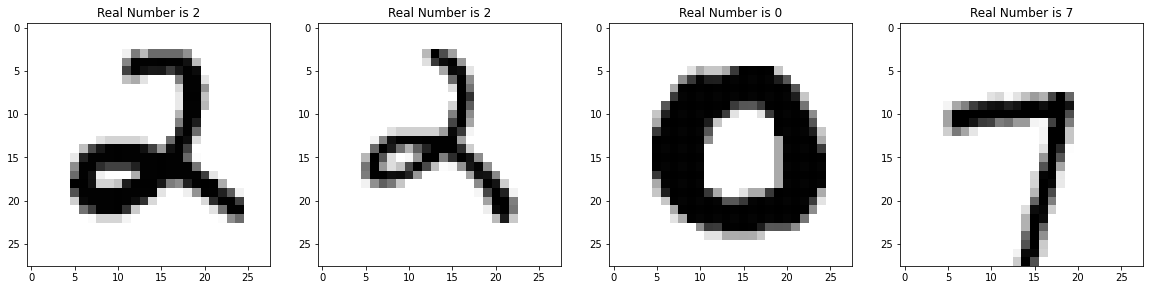

In [28]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

**Normalization function:**


In [29]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [30]:
epochs = 50
batch_size = 64

**CNN Model:**

In [31]:
model=Sequential()

model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

**Data augmentation:**

In [32]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [33]:
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

**Model training:**

In [34]:
#fit the model
model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)


Epoch 1/50
590/590 [==============================] - 15s 25ms/step - loss: 0.1528 - accuracy: 0.9524 - val_loss: 0.1089 - val_accuracy: 0.9707
Epoch 2/50
590/590 [==============================] - 14s 25ms/step - loss: 0.0683 - accuracy: 0.9787 - val_loss: 0.0777 - val_accuracy: 0.9784
Epoch 3/50
590/590 [==============================] - 14s 24ms/step - loss: 0.0577 - accuracy: 0.9828 - val_loss: 0.0488 - val_accuracy: 0.9846
Epoch 4/50
590/590 [==============================] - 15s 25ms/step - loss: 0.0465 - accuracy: 0.9859 - val_loss: 0.0589 - val_accuracy: 0.9827
Epoch 5/50
590/590 [==============================] - 15s 25ms/step - loss: 0.0441 - accuracy: 0.9873 - val_loss: 0.0545 - val_accuracy: 0.9849
Epoch 6/50
590/590 [==============================] - 14s 24ms/step - loss: 0.0389 - accuracy: 0.9884 - val_loss: 0.0419 - val_accuracy: 0.9875
Epoch 7/50
590/590 [==============================] - 14s 24ms/step - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.0566 - val_accuracy:

**Confusion matrix:**

In [35]:

y_pred = model.predict(X_test) # Predict encoded label as 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

In [36]:
mat

array([[421,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0, 468,   0,   0,   1,   0,   0,   4,   0,   0],
       [  1,   0, 407,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0, 423,   0,   1,   0,   2,   0,   0],
       [  0,   0,   0,   0, 426,   0,   0,   2,   0,   1],
       [  0,   0,   0,   0,   0, 381,   1,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0, 411,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0, 467,   0,   0],
       [  0,   0,   1,   0,   0,   0,   1,   0, 382,   0],
       [  0,   0,   0,   0,   2,   0,   0,   1,   2, 389]])

**Prediction validation results:**

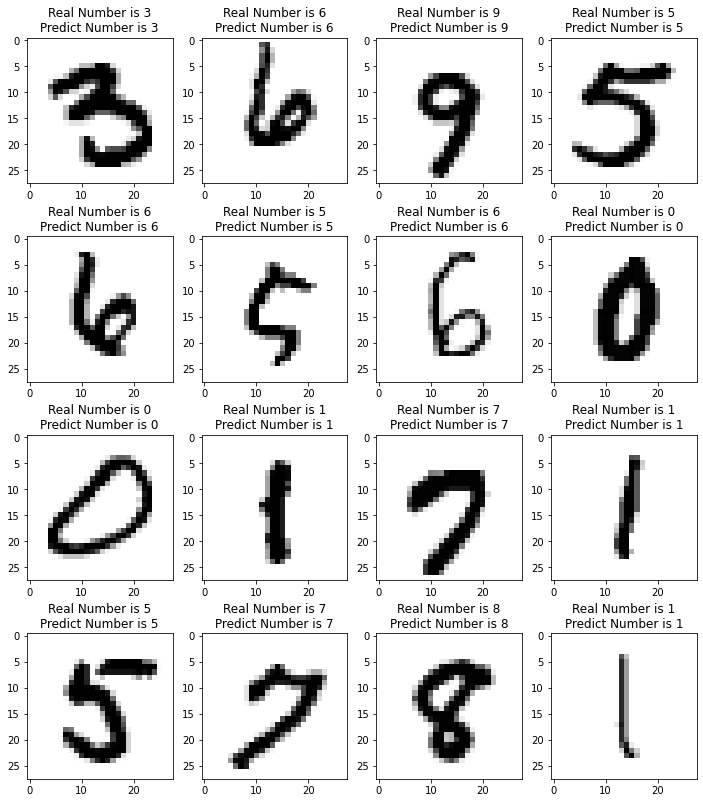

In [37]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");